# Large language models (LLMs): Part II

Author: Archit Vasan , including materials on LLMs by Varuni Sastri, and discussion/editorial work by Taylor Childers, Carlo Graziani, Bethany Lusch, and Venkat Vishwanath (Argonne)

Some inspiration from the blog post "The Illustrated Transformer" by Jay Alammar, highly recommended reading.

Before you begin, make sure that you have your environment set up and your repo refreshed, as described in previous lessons, and reviewed in the accompanying 'Readme.md' file. Make sure that you select the kernel 'datascience/conda-2023-10-04' at the top-left of the Jupyter notebook.

## Overview
1. Training and inference using Hugging Face
2. Elements of an LLM
3. Attention mechanisms
4. Positional encoding
5. Output layers
6. Training loops

## LLM training and inference using HuggingFace

<img src="images/hf-logo-with-title.png" alt="Drawing" style="width: 300px;"/>
HuggingFace is a platform and community that provides open-source library tools and resources like pre-trained models and datasets.
Refer to the following links for more information :

https://huggingface.co/docs/hub/index

https://huggingface.co/docs/transformers/en/index

### Inference

We can use the Huggingface pipeline with a pretrained GPT2 model to generate text given a prompt.

In [2]:
from transformers import AutoTokenizer,AutoModelForCausalLM, AutoConfig
input_text = "My dog really wanted to"
from transformers import pipeline
generator = pipeline("text-generation", model="openai-community/gpt2")
generator(input_text, max_length=100, num_return_sequences=5)

My dog really doesn't like his dad and is pretty big... what about your dog?

### Training

We can also load in our own dataset and train a model with this data as follows:

In [1]:
### Include Code for Fine-tuning the model

## What is going on below the hood?

There are two components that are "black-boxes" here:
1. The method for tokenization
2. The model that generates novel text.

Carlo Graziani already gave a great explanation of tokenization last week and how this affects embeddings (https://github.com/argonne-lcf/ai-science-training-series/blob/main/04_intro_to_llms/Sequential_Data_Models.ipynb)

Today we will take a closer look at how the model is designed to deal with language.

Let's look inside GPT2! GPT2 incorporates the `GPT2LMHeadModel` architecture so let's inspect this more closely.

In [2]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
model = GPT2LMHeadModel.from_pretrained('gpt2')
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


## General elements of an LLM

GPT-2 is an example of the popular Transformer architecture. 


<img src="images/decoder_only_block.png" alt="Drawing" style="width: 200px;"/>

The gray section in this figure is the Transfomer Decoder and it is the main mechanism GPT2 uses to encode context of language into its predictions.

<img src="images/transformer-decoder-intro.png" alt="Drawing" style="width: 600px;"/>


The Transformer-Decoder is composed of a series of Decoder blocks which each contain two types of layers: 
1. Masked Self-Attention and 
2. Feed Forward Neural Networks.

You have already discussed Feed Forward Neural Networks in detail in the other lectures in this series. To review this, please look at https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/01_introduction_mnist.ipynb

In this lecture, we will 
* First, discuss attention mechanisms at length as this is arguably the greatest contribution by Transformers.
* Second, extend the discussion from last week (https://github.com/argonne-lcf/ai-science-training-series/blob/main/04_intro_to_llms/Sequential_Data_Models.ipynb) on embedding input data while taking into account position.
* Third, discuss outputting real text/sequences from the models.
* Fourth, build a training loop for a mini-LLM.

**Let's set up all the imports and hyperparameters we will need**

In [8]:
## IMPORTS

import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

## Attention mechanisms

Say the following sentence is an input sentence we want to translate using an LLM:

`”The animal didn't cross the street because it was too tired”`

Last week, Carlo mentioned that the Transformer learns an embedding of all words allowing interpretation of meanings of words.

<img src="images/viz-bert-voc-verbs.png" alt="Drawing" style="width: 400px;"/>

So, if the model did a good job in token embedding, it will "know" what all the words in this sentence mean. 

But to understand a full sentence, the model also need to understand what each word means in relation to other words.

For example, when we read the sentence:
`”The animal didn't cross the street because it was too tired”`
we know intuitively that the word `"it"` refers to `"animal"`, the state for `"it"` is `"tired"`, and the associated action is `"didn't cross"`.

However, the model needs a way to learn all of this information in a simple yet generalizable way.
What makes Transformers particularly powerful compared to earlier sequential architectures is how it encodes context with the **attention mechanism**.

As the model processes each word in the input sequence, attention looks at other positions in the input sequence for clues to a better understanding for this word.

<img src="images/transformer_self-attention_visualization.png" alt="Drawing" style="width: 300px;"/>

Image credit: https://jalammar.github.io/illustrated-transformer/

For self-attention there are 5 general steps:

1. Generate query, key and value vectors for each word
2. Calculate a score for each word in the input sentence against each other.
3. Divide the scores by the square root of the dimension of the key vectors to stabilize the gradients. This is then passed through a softmax operation.
4. Multiply each value vector by the softmax score.
5. Sum up the weighted value vectors to produce the output.

<img src="images/self-attention-output.png" alt="Drawing" style="width: 450px;"/>

Image credit: https://jalammar.github.io/illustrated-transformer/

Let's see how attention is performed in the code.

In [13]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# Here we want the wei to be data dependent - ie gather info from the past but in a data dependant way

head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16) # each token here (totally B*T) produce a key and query in parallel and independently
q = query(x) # (B, T, 16)
v = value(x)

wei =  q @ k.transpose(-2, -1) * head_size**-0.5 # (B, T, 16) @ (B, 16, T) ---> (B, T, T). #
wei = F.softmax(wei, dim=-1) # exponentiate and normalize giving a nice distibution that sums to 1 and
                             # now it tells us that in a data dependent manner how much of info to aggregate from

out = wei @ v # aggregate the attention scores and value vector.


In [14]:
print("Softmax")
print(wei[0])
print("\nOutput")
print(out[0])

Softmax
tensor([[0.0728, 0.0818, 0.1304, 0.1943, 0.0867, 0.1849, 0.1481, 0.1011],
        [0.0518, 0.0788, 0.1224, 0.2774, 0.0691, 0.1547, 0.1176, 0.1283],
        [0.1152, 0.1086, 0.1517, 0.1353, 0.1163, 0.1041, 0.1516, 0.1172],
        [0.1769, 0.1190, 0.1337, 0.1176, 0.1264, 0.1085, 0.1053, 0.1125],
        [0.0855, 0.1177, 0.0962, 0.0842, 0.1949, 0.1454, 0.1285, 0.1476],
        [0.0913, 0.1806, 0.0960, 0.0770, 0.2278, 0.0525, 0.1408, 0.1339],
        [0.1391, 0.1732, 0.0992, 0.0979, 0.1234, 0.1452, 0.0924, 0.1296],
        [0.0845, 0.1197, 0.1078, 0.1537, 0.1086, 0.1146, 0.1558, 0.1553]],
       grad_fn=<SelectBackward0>)

Output
tensor([[ 0.0618, -0.0091, -0.3488,  0.3208,  0.2971, -0.1573, -0.0561,  0.1068,
          0.0368,  0.0139, -0.0017,  0.3110,  0.1404, -0.0158,  0.1853,  0.4290],
        [ 0.1578, -0.0971, -0.4256,  0.3538,  0.3621, -0.2392, -0.0536,  0.1759,
          0.1115,  0.0282, -0.0649,  0.3641,  0.1928,  0.0261,  0.2162,  0.3758],
        [ 0.1293,  0.0759, -0.2

### Multi-head attention

In practice, multiple attention heads are used which
1. Expands the model’s ability to focus on different positions and prevent the attention to be dominated by the word itself.
2. Have multiple “representation subspaces”. Have multiple sets of Query/Key/Value weight matrices

<img src="images/transformer_multi-headed_self-attention-recap.png" alt="Drawing" style="width: 700px;"/>

Image credit: https://jalammar.github.io/illustrated-transformer/

### Let's see attention mechanisms in action!

The attention mechanisms can be significantly more complex as the number of heads increases!

We are going to use the powerful visualization tool bertviz, which allows an interactive experience of the attention mechanisms. Normally these mechanisms are abstracted away but this will allow us to inspect our model in more detail.

In [31]:
!pip install bertviz

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Let's load in the model, GPT2 and look at the attention mechanisms. 

**Hint... click on the different blocks in the visualization to see the attention**

In [2]:
from transformers import AutoTokenizer, AutoModel, utils, AutoModelForCausalLM

from bertviz import model_view
utils.logging.set_verbosity_error()  # Suppress standard warnings

model_name = 'openai-community/gpt2'
input_text = "No, I am your father"  
model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)
inputs = tokenizer.encode(input_text, return_tensors='pt')  # Tokenize input text
outputs = model(inputs)  # Run model
attention = outputs[-1]  # Retrieve attention from model outputs
tokens = tokenizer.convert_ids_to_tokens(inputs[0])  # Convert input ids to token strings
model_view(attention, tokens)  # Display model view

### Positional encoding

**Positional encoding** accounts for the order of the words in the input sequence.

Consider the following two sentences to see why this is important:

``The man ate the sandwich.``

``The sandwich ate the man.``

Clearly, these are two vastly different situations even though they have the same words.

Transformers differentiate between these situations by adding a vector to each input embedding. These vectors follow a specific pattern that the model learns, which helps it determine the position of each word.

<img src="images/transformer_positional_encoding_vectors.png" alt="Drawing" style="width: 500px;"/>

Image credit: https://jalammar.github.io/illustrated-transformer/

First, we are going to setup the token embedding using the ``nn.Embedding`` function in pytorch:

In [9]:
vocab_size = 65
token_embedding_table = nn.Embedding(vocab_size, n_embd)

Here, we set this up similarly as token embedding using the ``nn.Embedding`` tool. We use a simple embedding here but there are more complex positional encodings used such as sinusoidal. 

For an explanation of different positional encodings, refer to this post: https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/

In [10]:
position_embedding_table = nn.Embedding(block_size, n_embd)

Then, the position embedding used is simply added to the token embedding to apply positional embedding.

In [11]:
x = torch.tensor([1,3,15,4,7,1,4,9])
x = token_embedding_table(x)
print("Token embedding alone")
print(x)

Token embedding alone
tensor([[-8.3447e-01,  5.9780e-01, -5.1406e-02, -6.4559e-02, -4.9701e-01,
          4.6576e-01, -2.5726e-01, -1.0673e+00,  2.0089e+00, -5.3698e-01,
          2.2280e-01,  6.9705e-01, -1.4267e+00,  9.0594e-01,  1.4459e-01,
          2.2800e-01,  2.4900e+00, -1.2237e+00,  1.0107e+00,  5.5600e-01,
         -1.5935e+00, -1.2706e+00,  6.9033e-01, -1.9614e-01,  3.4491e-01,
         -3.4189e-01,  4.7587e-01, -7.6634e-01, -4.1896e-01, -4.3699e-01,
         -1.0012e+00, -4.0943e-01, -1.6669e+00, -1.3651e+00, -1.6552e-01,
          9.6225e-01,  3.1549e-02, -7.4190e-01, -2.9779e-01,  1.7166e-02,
         -1.7722e-01, -1.3343e-01,  2.9396e-01,  1.3850e+00,  1.2091e-01,
          2.5418e+00, -6.4046e-01, -1.9740e+00, -3.2957e-01,  7.9589e-03,
          9.2623e-01, -1.8846e+00,  1.6696e-01,  4.5862e-01, -1.7662e+00,
          5.8599e-01,  1.7510e+00,  2.8072e-01,  3.1096e-01, -6.5376e-01,
         -6.5763e-01,  3.1845e-01, -5.4959e-01, -1.4649e+00],
        [ 1.9098e-01, -3.425

In [12]:
x = torch.tensor([1,3,15,4,7,1,4,9])
x= position_embedding_table(x) + token_embedding_table(x)
print("\nToken embedding with position")
print(x)


Token embedding with position
tensor([[-1.0484,  2.2665,  0.3666,  1.0574, -0.9951,  2.2462, -0.6011, -0.9756,
          1.5423, -1.4911,  0.6471,  0.2819, -2.3785, -0.0471, -0.4105,  1.2946,
          2.3024, -0.4476,  0.9871,  1.3254, -1.0561, -0.7877, -0.4755, -1.0040,
          0.0557, -1.0481,  0.2423, -0.6688,  1.7516,  0.3538, -1.4136,  0.3590,
         -1.7820, -1.3862, -0.0066,  0.5300,  0.9194, -0.5648,  0.5546, -0.3695,
         -1.4549, -0.5651,  1.0933,  2.2977,  0.4996,  2.1042,  0.0657, -3.3093,
         -1.8844, -0.1384,  1.2181, -2.0103,  0.2392,  0.2019, -1.4201,  1.1310,
          1.4464, -0.7095,  0.3363, -2.0127, -1.5222,  0.2868, -1.6676,  0.1696],
        [-0.3105, -0.7262,  0.9597, -0.2898,  1.8560, -1.5758,  0.7106,  2.3958,
          0.5443, -0.2576,  2.0226,  1.6060,  0.6541, -0.3406,  0.5152, -0.1032,
         -0.8500, -0.8411,  0.3791, -0.0454,  1.1482,  1.8933,  2.5476,  0.0518,
         -0.7114,  1.0657,  0.1492,  1.7766,  1.0025, -0.5372, -1.7718, -0.00

#### TODO: Add visualization of token vs positional encoding

## Let's put the pieces together to train a mini-LLM from scratch

### Set up hyperparameters:

In [26]:
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 10
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4
dropout = 0.0
# ------------

### Load in data and create train and test datasets

We're going to be using the tiny Shakespeare dataset. 
Data is tokenized according to a simple character based tokenizer.
Data is split into a train and test set so we have something to test after performing training (9:1 split).

In [17]:
with open('dataset/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print (vocab_size)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

65


### Set up the components of the LLM: 
* MultiHeadAttention
* FeedForward Network

In [18]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C) 16,32,16
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd), # Projection layer going back into the residual pathway
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


### Combine components into the Transformer block

In [19]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))    # Communication
        x = x + self.ffwd(self.ln2(x))  # Computation
        return x

### Set up the Transformer model 
This is a combination of the Token embeddings, Positional embeddings, Transformer block and an output block.

Let's briefly discuss the output block.

#### How do we turn the output of the decoder stack into a word?

Using the final Linear layer and a Softmax Layer.

The Linear layer projects the vector produced by the stack of decoders, into a larger vector called a logits vector.

If our model knows 10,000 unique English words learned from its training dataset the logits vector is 10,000 cells wide – each cell corresponds to the score of a unique word.

The softmax layer turns those scores into probabilities. The cell with the highest probability is chosen, and the word associated with it is produced as the output for this time step.

<img src="images/transformer_decoder_output_softmax.png" alt="Drawing" style="width: 500px;"/>

Image credit: https://jalammar.github.io/illustrated-transformer/

In [20]:
# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx



### Training loop

Our model produces a probability distribution for each token. We want to compare these probability distributions to the ground truths. 
To compare these distributions we can simply look at the difference between them a loss like cross-entropy or Kullback–Leibler divergence. Then the training uses back-propagation to optimize this loss function.

A more complex situation is translating the sentence: “je suis étudiant” into “i am a student” as can be seen in the example:

<img src="images/output_target_probability_distributions.png" alt="Drawing" style="width: 500px;"/>

In this example, we are using cross entropy loss.

In [27]:
import torch

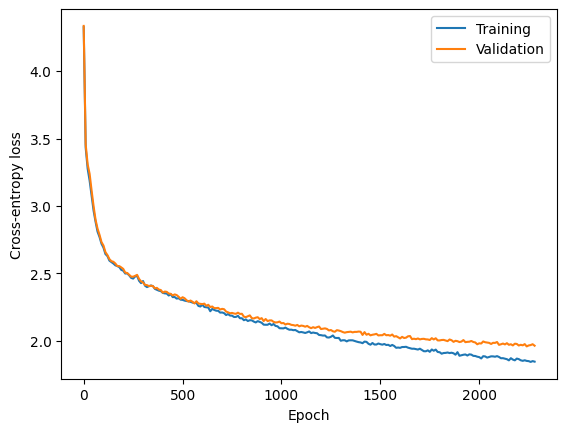

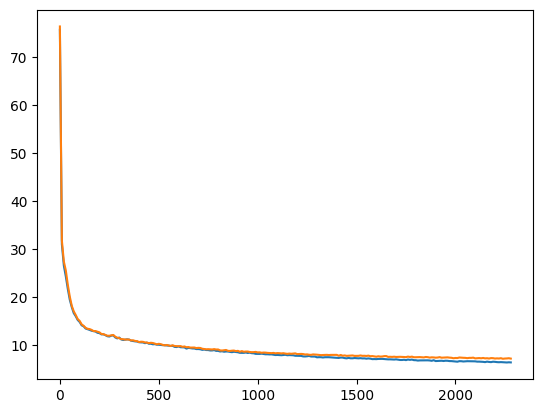

step 2280: train loss 1.8457, val loss 1.9640


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out
    
model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

loss_train = []
perplex_train = []

loss_val = []
perplex_val = []
iterations_plot = []
for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        time.sleep(0.25)
        clear_output(wait=True)
        sys.stdout.flush()
        losses = estimate_loss()
        loss_train.append(losses['train'])
        iterations_plot.append(iter)
        perplex_train.append(np.exp(losses['train']))
        loss_val.append(losses['val'])
        perplex_val.append(np.exp(losses['val']))
        
        plt.plot(iterations_plot, loss_train, label='Training')
        plt.plot(iterations_plot, loss_val, label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Cross-entropy loss')
        plt.legend()
        plt.show()
        
        plt.plot(iterations_plot, perplex_train, label='Training')
        plt.plot(iterations_plot, perplex_val, label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Perplexity')
        plt.show()
        
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))